<a href="https://colab.research.google.com/github/Tasfia48/CS584/blob/main/HW3_Mashiat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   Team : "chi"
*   Part 1 Rank: 19 Score: 0.95
*   Part 2 Rank: 40 Score: 0.79

In [ ]:
#Load the necessary python libraries
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import random
import json
from json import JSONEncoder

### K-means Algorithm

Kmeans algorithm is an iterative algorithm that tries to partition the dataset into K pre-defined distinct non-overlapping subgroups (clusters) where each data point belongs to only one group. It tries to make the intra-cluster data points as similar as possible while also keeping the clusters as different (far) as possible. It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster’s centroid (arithmetic mean of all the data points that belong to that cluster) is at the minimum. 

I tried to measure the distace between centroids and data points using three different similarity functions:  Euclidean, Manhattan and Cosine Similarity. Among these three metrices, Euclidean performed best. I used sum of the squared errors(SSE) instead of v-score as goodness of fit, since the ground truth was not available.  
K-means Algorithm Description:
---
In my K- means algorithm I took the similarity function, the data, the number of clusters, initial centroids and maximum number of iteration as function argument. For all tuples I computed the similarity(cosine) or distance measure(Euclidean, Manhattan) with respect to each initial centroids. Based on maximum similarity or minimum distance I divided the datapoints into groups. For number of clusters = 3 there will be three groups. I replaced the centroids with the mean of each cluster. I continued to do this process untill the centroid were changing. As soon as the centroids were not changing, I stopped the process and returned the final centroids, clusters and cluster ids for each datapoints.  



In [ ]:
def kmeans_custom(distanceMeasure,k,dataItems,centroids,maxIter): 
    iter = 0
    num_attr = len(centroids[0])
    new_centroids = []
    groups = []
    cluster_ids = []
    while(iter < maxIter):
        groups = []
        cluster_ids = []
        for i in range(k):
          groups.append([])

        if (distanceMeasure=="Cosine"):
          row = []
          similarity = cosine_similarity(dataItems, centroids, dense_output=False).tolist()
          for i in range(len(similarity)):
            row = similarity[i] 
            # print(max(similarity[i]))
            idx = row.index(max(row))
            groups[idx].append(dataItems[i])
            cluster_ids.append(idx)
        else:
          for item in dataItems:
            row = []
            for centroid in centroids:
              diff = 0
              for i in range(num_attr):
                if (distanceMeasure =="Euclidean"):
                  diff += pow((item[i] - centroid[i]),2)
                elif (distanceMeasure=="Manhattan"):
                  diff += abs(item[i] - centroid[i])
              row.append(diff)               
            idx = row.index(min(row))
            groups[idx].append(item)
            cluster_ids.append(idx)

        new_centroids = []
        for i in range(len(groups)):
          group = groups[i]
          if len(group):
            new_centroids.append(np.mean(group,axis=0).tolist()) # taking the mean of the clusters as the new centroid
          else:
            new_centroids.append(centroids[i]) #if any group do not have any data point I will keep the previous centroid
        if(np.array_equal(centroids,new_centroids)): # continue updating the 
          #print("they are equal, break !!",iter)
          return (new_centroids, cluster_ids, groups)
        else:
          centroids = new_centroids
                    
        iter += 1
    
    return (new_centroids, cluster_ids, groups)    


SSE is the sum of the squared differences between each observation and its group's mean. It can be used as a measure of variation within a cluster. If all cases within a cluster are identical the SSE would then be equal to 0.

The formula for SSE is:

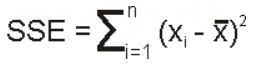



In [ ]:
# Calculating SSE
def calculate_SSE( centroids,groups):
  sse = 0
  num_attr = len(centroids[0])
  k = len(groups) 
  # print(num_attr,k) 
  for i in range(k):
    for item in groups[i]:
      for j in range(num_attr):
        diff = abs(item[j]- centroids[i][j])
        sse += pow(diff,2)
            
  return (sse)

Part 1

In [ ]:
#Loading iris data set
Col_name = ['zero','one','two','three','four']
dfIris = pd.read_csv('/content/1601384279_9602122_iris_new_data.txt',names=Col_name, header=None)
dfIris['one'] = dfIris['zero'].str.split(' ').str[0]
dfIris['two'] = dfIris['zero'].str.split(' ').str[1]
dfIris['three'] = dfIris['zero'].str.split(' ').str[2]
dfIris['four'] = dfIris['zero'].str.split(' ').str[3]
dfIris= dfIris.drop(columns={'zero'})
dfIris=dfIris.astype("float")
iris = dfIris.values.tolist()
dfIris.head(5)

,one,two,three,four
0,5.7,4.4,1.5,0.4
1,5.5,4.2,1.4,0.2
2,5.2,4.1,1.5,0.1
3,5.8,4.0,1.2,0.2
4,5.4,3.9,1.7,0.4


Random Centroid: Intially to select the correct similarity function for k=3, I took three random initial centroid points for the iris dataset and computed the SSE for each of them.

In [ ]:
random_centroids = random.choices(iris, k=3)

In [ ]:
centroids, cluster_ids, groups =kmeans_custom("Cosine",3,iris,random_centroids,1000)
print("SSE for Cosine Similarity",calculate_SSE(centroids, groups))

SSE for Cosine Similarity 92.07870917874396


In [ ]:
centroids, cluster_ids, groups =kmeans_custom("Manhattan",3,iris,random_centroids,1000)
print("SSE for Manhattan Distance",calculate_SSE(centroids, groups))

SSE for Manhattan Distance 79.14342874302875


In [ ]:
centroids, cluster_ids, groups =kmeans_custom("Euclidean",3,iris,random_centroids,1000)
print("SSE for Euclidean Distance",calculate_SSE(centroids, groups))

SSE for Euclidean Distance 78.94506582597738




*   SSE for Cosine Similarity 92.07870917874396
*   SSE for Manhattan Distance 79.14342874302875
*   SSE for Euclidean Distance 78.94506582597738



Euclidean distance performed better than other two measures.So, I decided to continue further exploration using the euclidean distance. Initial centroid selection. I took random centroid points for 100 times and stored the centroid point which had the least SSE score among the clusters.

In [ ]:
def initial_centroids(iris,j):
  maxVal = 9999999
  centroid=[]
  for i in range(0,100):
    random_centroids = random.choices(iris, k=j)
    centroids, cluster_ids, groups = kmeans_custom("Euclidean",j,iris,random_centroids,1000)
    calculatedSSE = calculate_SSE(centroids, groups)
    if (calculatedSSE <= maxVal):
      maxVal = calculatedSSE
      centroid=random_centroids
  return centroid

In [ ]:
SSE=[]
k_Values=np.arange(2,21,2)
for i in range(2,21,2):
  centroid=initial_centroids(iris,i)  
  centroids, cluster_ids, groups = kmeans_custom("Euclidean",i,iris,centroid,1000)
  calculatedSSE = calculate_SSE(centroids, groups)
  SSE.append(calculatedSSE)

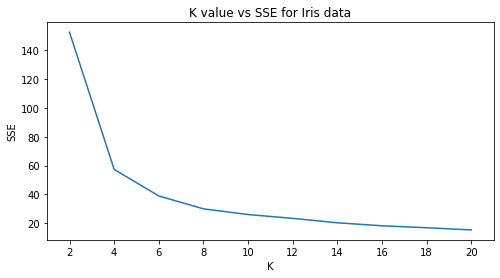

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(k_Values,SSE)
plt.xlim(1,21)
plt.xscale('linear')
plt.xticks(ticks=k_Values)
plt.xlabel("K")
plt.ylabel("SSE")
plt.title("K value vs SSE for Iris data")
plt.show()

From the figure we can see that, the elbow is at K=4. But we already know that there are 3 classes or clusters for this dataset. Hence, I decided to use K=3, for the remainder part of this assignment.

In [ ]:
initial = initial_centroids(iris,3)
centroids, cluster_ids, groups =kmeans_custom("Euclidean",3,iris,initial,1000)
print("SSE for Euclidean Distance",calculate_SSE(centroids, groups))

SSE for Euclidean Distance 78.94084142614594


In [ ]:
dfIris['outcome'] = cluster_ids
dfIris['outcome'] = dfIris['outcome']+1

I am using Principal Component Analysis(PCA) to visulaize the data points based on Cluster Labels. I have reducedthe data set into two dimensions, PC1 and PC2 and ploted the cluster label based on these two components. PCA performs a linear mapping of the data to a lower-dimensional space in such a way that the variance of the data in the low-dimensional representation is maximized.

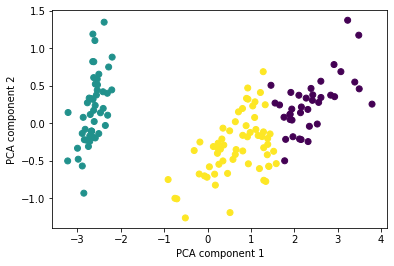

In [ ]:
pca = PCA(n_components=2)
X = pca.fit_transform(iris)
cl = dfIris['outcome'].values
plt.scatter(X[:,0],X[:,1],c=cl)
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.show()

In [ ]:
#uploading Clustered labels to the format2.txt file
with open('format1.txt', 'w') as filehandle:
    for listitem in dfIris['outcome'].values:
        filehandle.write('%s\n' % listitem)

###Part2

In [ ]:
Col_name = np.arange(784)
df = pd.read_csv('/content/1601384482_8387134_image_new_test.txt',names=Col_name, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


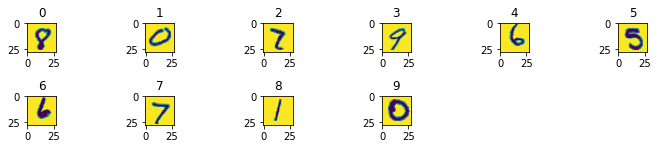

In [ ]:
# show image for each row
def show_images(rows,w=28,h=28):
  plt.figure(figsize=(10,6))
  for i,row in rows.iterrows():
    ax= plt.subplot(6,6 ,i+1)
    pixels = 255-np.array(row.values, dtype='uint8')
    im=ax.imshow(pixels.reshape((w,h)))
    plt.tight_layout()
    plt.title(i)
show_images(df.iloc[0:10])

Pre-processing

In [ ]:
# Normalizing Data
df = df.div(255)

This dataset has multiple columns, with value of zero. which can suffer for the curse of dimentionality. In order to remove the curse, I applied PCA, TruncatedSVD and TSNE for preprocessing the data to reduce the dimentionality and noise in data. 

PCA
---
The main linear technique for dimensionality reduction, principal component analysis, performs a linear mapping of the data to a lower-dimensional space in such a way that the variance of the data in the low-dimensional representation is maximized.

TruncatedSVD
---
Dimensionality reduction using truncated SVD.This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently.Truncated SVD is different from regular SVDs in that it produces a factorization where the number of columns is equal to the specified truncation. For example, given an n x n matrix, SVD will produce matrices with n columns, whereas truncated SVD will produce matrices with the specified number of columns. This is how the dimensionality is reduced.

TSNE
---
t-distributed Stochastic Neighbor Embedding. t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results. The t-SNE algorithm comprises two main stages. First, t-SNE constructs a probability distribution over pairs of high-dimensional objects in such a way that similar objects are assigned a higher probability while dissimilar points are assigned a lower probability. Second, t-SNE defines a similar probability distribution over the points in the low-dimensional map, and it minimizes the Kullback–Leibler divergence (KL divergence) between the two distributions with respect to the locations of the points in the map.




SSE for Euclidean Distance 300651.8145632584


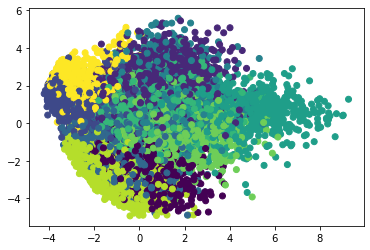

In [ ]:
# I randomly picked 10 inital centroids to compare the SSE values for each dimentionality reduction methods and select the best performing one.
# With only PCA
pca = PCA(n_components=50) #reduce the number of dimensions to 50
X = pca.fit_transform(df)
initial = random.choices(X, k=10)
centroids, cluster_ids, groups =kmeans_custom("Euclidean",10,X,initial,1000)
print("SSE for Euclidean Distance",calculate_SSE(centroids, groups))
df['outcome'] = cluster_ids
df['outcome'] = df['outcome']+1
cl = df['outcome'].values
plt.scatter(X[:,0],X[:,1],c=cl)
plt.show()

SSE for Euclidean Distance 299084.91047290544


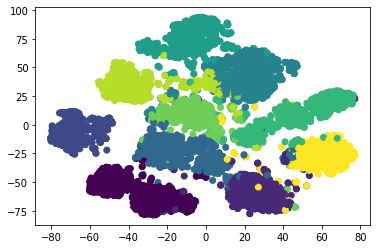

In [ ]:
# I randomly picked 10 inital centroids to compare the SSE values for each dimentionality reduction methods and select the best performing one.
# With PCA and TSNE
pca = PCA(n_components=50) #reduce the number of dimensions to 50
X = pca.fit_transform(df)
X_embedded = TSNE(n_components=2).fit_transform(X) #reduce the number of dimensions to 2

centroids, cluster_ids, groups =kmeans_custom("Euclidean",10,X,initial,1000)
print("SSE for Euclidean Distance",calculate_SSE(centroids, groups))
df['outcome'] = cluster_ids
df['outcome'] = df['outcome']+1
cl = df['outcome'].values
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=cl)
plt.show()

In [ ]:
# I randomly picked 10 inital centroids to compare the SSE values for each dimentionality reduction methods and select the best performing one.
# With TruncatedSVD and TSNE
trun_50 = TruncatedSVD(n_components=50) #reduce the number of dimensions to 50
trun_result50 = trun_50.fit_transform(df)
X_embedded = TSNE(n_components=2).fit_transform(trun_result50) #reduce the number of dimensions to 2
random_centroids = random.choices(X_embedded, k=10)

In [ ]:
centroids, cluster_ids, groups =kmeans_custom("Euclidean",10,X_embedded,random_centroids,1000)
print("SSE for Euclidean Distance (Truncated SVD and TSNE)",calculate_SSE(centroids, groups))

SSE for Euclidean Distance (Truncated SVD and TSNE) 2614528.8832431785


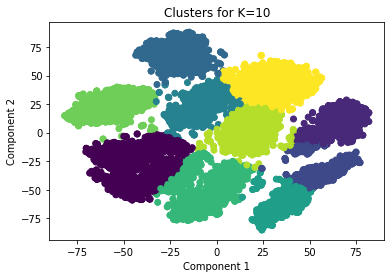

In [ ]:
df['outcome'] = cluster_ids
df['outcome'] = df['outcome']+1
df.head()
cl = df['outcome'].values
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=cl)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Clusters for K=10")
plt.show()

The SSE score was least when I applied TruncatedSVD as dimensionality reduction method to reduce the number of dimensions to 50 which is a a reasonable amount. As the number of features is very high, this suppressed some noise and speed up the computation of pairwise distances between samples. 
SSE scores:
*   PCA : 300651.814
*   PCA and TSNE: 299084.91
*   TruncatedSVD and TSNE:2614528.88
---
So, I decided to continue the exploration with truncatedSVD and TSNE. 
The above figure shows the density of clusters accorss two components of the dataset.



In [ ]:
# Storing the best initial centroid for 100 random runs
initial = initial_centroids(X_embedded,10) # initial centroid after 100 random selection
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)
with open('my_dict.json', 'w') as f:
    json.dump(initial, f,cls=NumpyArrayEncoder) # stored in a json file for futher use

Calculating SSE for different values of K (2-20).

In [ ]:
SSE={}
k_Values=np.arange(2,21,2)
for i in range(2,21,2):
  centroid=random.choices(X_embedded,k=i)  
  centroids, cluster_ids, groups = kmeans_custom("Euclidean",i,X_embedded,centroid,1000)
  calculatedSSE = calculate_SSE(centroids, groups)
  SSE[i]=calculatedSSE

In [ ]:
with open('SSEImage.json', 'w') as f:
    json.dump(SSE, f)

In [ ]:
#Loading dictionaries with SSE with K values. Keys: K value, Value: SSE
with open('SSEImage.json') as f:
  values = json.load(f)
SSE = {}
for key in values.keys():
    SSE[int(key)] = values[key] # converting the datatype of dictinary to int for ploting purpose 

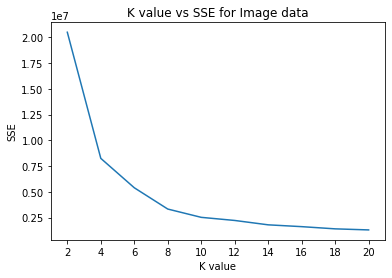

In [ ]:
lists = sorted(SSE.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y)
plt.xlim(1,21)
plt.xscale('linear')
plt.xticks(ticks=x)
plt.xlabel("K value")
plt.ylabel("SSE")
plt.title("K value vs SSE for Image data")
plt.show()

From the figure we can see that, the elbow is at K=4. But we already know that there are 10 classes or clusters for this dataset. Hence, I decided to use K=10, for the remainder part of this assignment.

In [ ]:
with open('my_dict.json') as f:
    temp = json.load(f)

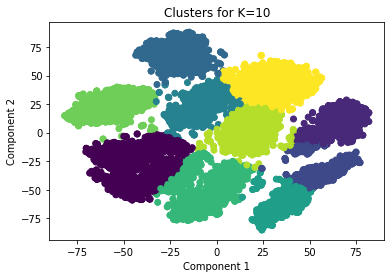

In [ ]:
centroids, cluster_ids, groups =kmeans_custom("Euclidean",10,X_embedded,temp,1000)
df['outcome'] = cluster_ids
df['outcome'] = df['outcome']+1
df.head()
cl = df['outcome'].values
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=cl)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Clusters for K=10")
plt.show()

In [ ]:
#uploading Clustered labels to the format2.txt file
with open('format2.txt', 'w') as filehandle:
    for listitem in df['outcome'].values:
        filehandle.write('%s\n' % listitem)